In [1]:
from sklearn.datasets import fetch_openml
import numpy as np

In [2]:
mnist = fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape
   

(70000, 784)

In [4]:
y.shape

(70000,)

There are 70,000 Images with 784 features each. 784 = 28x28 image RGB array. Each feature represents the intensity of a pixel and varies from 0 to 255.

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

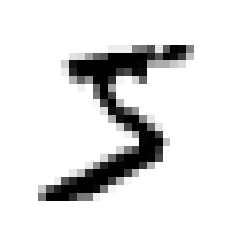

In [6]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation = "nearest")
plt.axis("off")
plt.show()

In [7]:
y[0]

'5'

In [8]:
y = y.astype(np.uint8)

Before we even try to do anything, let us set aside some part of our data as test set, and not touch it until we are done training our model.

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Let us first start with a binary classifier. That is, classifying images into '5' or non 5 images. 

Create target vectors for this classification task as follows: 

In [10]:
y_train_5 = (y_train == 5)    #True for all 5, False for other digits.
y_test_5 = (y_test == 5)


Stochastic
Gradient Descent (SGD) classifier, using Scikit-Learn’s SGDClassifier class. This clas‐
sifier has the advantage of being capable of handling very large datasets efficiently.
This is in part because SGD deals with training instances independently, one at a time
(which also makes SGD well suited for online learning), as we will see later. Let’s create
an SGDClassifier and train it on the whole training set:

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [12]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

#### Evaluating a Classifier is more complex than a Regressor. 
Now we will measure accuracy using Cross Validation. 

In [13]:
#Like earlier, let us use Scikit-Learn's cross_val_score() function.

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [14]:
skfolds = StratifiedKFold(n_splits = 3, random_state = 42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


The StratifiedKFold class performs stratified sampling (as explained in Chapter 2)
to produce folds that contain a representative ratio of each class. At each iteration the
code creates a clone of the classifier, trains that clone on the training folds, and makes
predictions on the test fold. Then it counts the number of correct predictions and
outputs the ratio of correct predictions.

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [16]:
#Woah the accuracy is way too high.
#Let us see what happens if we classify all images as non-5. 

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)
    

In [17]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.91125, 0.90855, 0.90915])

###### Note:-
Even when we classified all images as non 5, we got 90% accuracy. This means that more than 90% of numbers in the MNIST dataset are non-5. Hence the data is highly skewed in this case. 
Hence accuracy is not the preferred performance measure for Classifiers, especially those with skewed datasets like this one. 

### Confusion Matrix

To check the performance of a Classifier, a better way would be to look at the number of errors, or the number of times the classifier classified an image incorrectly. hence we construct a confusion matrix. 
# 

For example, to know the number of times the classifier confused
images of 5s with 3s, you would look in the 5 th row and 3 rd column of the confusion
matrix.

# 

To compute the confusion matrix, you first need to have a set of predictions, so they
can be compared to the actual targets. Let us use cross_val_predict() function for that.

In [18]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)


Just like cross_val_score() performs K-fold cross validation and returns evaluation scores, cross_val predict() does the same, but returns predictions made on each test fold. Also, the prediction in this case is clean as the model does not see the data during training in this case. 

In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Each row in a confusion matrix represents an actual class, while each column represents a predicted class. The first row of this matrix considers non-5 images (the negative class): 53,057 of them were correctly classified as non-5s (they are called true negatives), while the remaining 1,522 were wrongly classified as 5s (false positives).
The second row considers the images of 5s (the positive class): 1,325 were wrongly
classified as non-5s (false negatives), while the remaining 4,096 were correctly classified as 5s (true positives).

#### A Perfect Classifier should have only true positives and true negatives

In [20]:
#Let us pretend we have a perfect classifier, in this case:

y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

Accuracy of positive predictions is known as # Precision of the Classsifier

precision = TP/(TP+FP)       

TP - True positives FP - False Positives

We could theoretically make and ensure just one correct positive predictionand then our precision = 1/1 = 100% 
But then this is not useful. Therefore we define another metric to be used with "precision", called as "recall" or "sensitivity" or "true positive rate"

recall = TP/(TP+FN)       FN - False Negatives

Scikit-Learn provides various functions that allow you to compute classfier metrics, for example: Precision and Recall

In [21]:
from sklearn.metrics import precision_score, recall_score # == 4096 / (4096 + 1522)
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [22]:
recall_score(y_train_5, y_train_pred)   # == 4096 / (4096 + 1325)

0.6511713705958311

Now these metrics are very important as we now understand that when the classifier claims an image represents a 5, it is true only 83.7% of the time.
Moreover, it only detects 65.1% of the 5's. 

It is often more convenient to combine precision and recall into a single metric called F1 score, in particular if you need a simple way to compare two classifiers. 
F1 score is the harmonic mean of precision and recall. Hence the formula for the same would be:

F1 = 2*(precision x recall)/(precision + recall)

   = TP / [TP + (FN+FP)/2]


In [23]:
#Directly call f1_score function from scikit-learn:

from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

So, this brings us to the discussion of the Precision / Recall Tradeoff. We can never have the best of the both worlds. However we can always tune our model for whichever one we want to be the more prominent in our case. For example, if we want to clssify videos as safe for kids, we may allow a lot of good videos being rejected instead of running the risk of letting even a few really bad videos to be allowed. This can be done by increasing prescision and therefore automatically reducing recall.

However for a classifier for identifying shoplifters in a store via CCTV, we want high recall and less precision. This way the guards will get a few false alerts(low precision) but almost all the shoplifters would be caught. 

## Precision/Recall Tradeoff

Look at SGDClassifier.

It complutes a score based on a decision function, and if the score is higher than a threshold value, it assigns the instance to a positive class or else to a negative class. 

The threshold that we set decides the values of Precision and Recall, and therefore the F1 score. SCikit-Learn doesn't let you set the threshold directly but does allow you access to the decision scores that it uses to make predicitions. Instead of calling the classifier's predict() method, we can call the decision_function() method, which returns a score for each instance, and then make predicitons based on those scores using any threshold we want. 

In [24]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [25]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

The SGD Classifier uses a threshold = 0, so previous code returns the same result as the predict() method. Raise the threshold:

In [26]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

Therfore this confirms that increasing the threshold(increasing accuracy) decreases recall.

To decide the threshold value to be used, we first use the cross_val_predict() function over all instances of training set, but this time we specify that we want it to return the decison scores of the predictions:

In [27]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = "decision_function")

In [28]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [29]:
np.size(y_scores)

60000

In [30]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

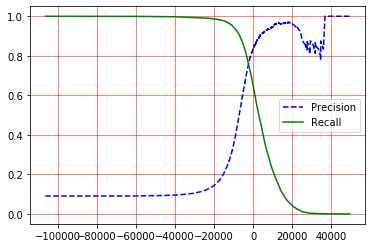

In [31]:
#Plotting precision and recall as a funciton of threshold value using Matplotlib:

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label = "Recall")
    plt.grid(linestyle='-', linewidth='0.5', color='red')
    plt.legend()
    
#Calling the above function:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Note : Precisoin may sometimes go down as we raise the threshold.(although it goes up generally). Recall the precision-recall explanatory figure in AGeron textbook. 
    However, recall always goes down. 

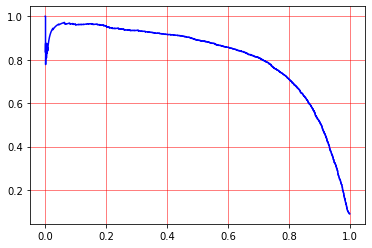

In [40]:
#Plotting Precision vs Recall
plt.plot(recalls[:-1], precisions[:-1], "b-", label = "Precision")
plt.grid(linestyle='-', linewidth='0.5', color='red')

Precision falls rapidly after 80% recall. 

Suppose we want 90% precision. We search for the lowest threshold that gives us precision = 90%.

np.argmax() will give us the index of the maximum value : the first True value. 

In [41]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [42]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [43]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [45]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

OOOOH WE got a 90 fucking percent on this classifier baby!

SO, the main thing that we learn from building this classifier is that although it is fairly easy to build a classifier with 90% precision, but it is indeed a difficult task to maintain both the precision and recall of the classifier too.

#### The Recall value of a classifier matters as much as its precision. In some cases, even more so.

## ROC Curve

The Reciever Operating Characterestics (ROC) curve is another common tool used with binary classifiers. It is similar to precision-recall curve but instead of plotting precision vs recall, ROC Curve plots the true positive rate (TPR - another name for recall) against the false positive rate (FPR). FPR is the ratio of negative instances that are incorrectly labelled as positive.

FPR = 1 - TNR

TNR = True Negative Rate  which is the ratio of negative instances correctly classified as negative. 
TNR is also called the Specificity.

### Hence ROC Curve plots sensitivity (recall) vs (1 - specificity)

to plot ROC, get the required values: 

In [46]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [56]:
#PLotting the ROC Curve:

def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0,1], [0,1], 'k--')    #dashed diagonal
    plt.grid(linestyle='-', linewidth='0.5', color='red')

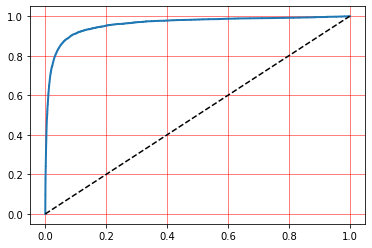

In [57]:
plot_roc_curve(fpr, tpr) #puts fpr on X-axis, tpr on Y-axis
plt.show()

Once again there is a tradeoff: the higher the recall (TPR), the more false positives
(FPR) the classifier produces. The dotted line represents the ROC curve of a purely
random classifier; a good classifier stays as far away from that line as possible (toward
the top-left corner).